## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, RandomAdjustSharpness, Grayscale, Normalize
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.CNN import *
from architecture.AutoEncoder import *
from architecture.Transformer import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [3]:
size = 32
batch_size = 128
transformation = Compose([RandomHorizontalFlip(), Resize((size, size)), Grayscale(1),
                          RandomAdjustSharpness(2, p=1),
                          ToTensor(), Normalize(mean=[0.4814], std=[0.2136])])

In [4]:
root = 'chest_xray/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

## Load AutoEncoder

In [5]:
# number of hidden layers and their sizes
hidden_a = [1, 32, 64, 128, 256]

# kernel size of convolution layers
kernel_size_a = 3

In [6]:
autoencmodel = AutoEncoder(hidden_a, kernel_size_a).to(device)
autoencmodel.load_state_dict(torch.load("./autoencoder256_4epochs")["model_state_dict"])
for param in autoencmodel.parameters():
    param.requiresGrad = False

## Best CNN

In [7]:
from math import floor
# kernel size of convolution layers
kernel_size = 3

# sharp sobel kernels (will have to update if kernel size increases)
# these will be the starting weights of the convolutional layers
kernels = [torch.tensor([[0., -1., 0.],
                        [-1., 5., -1.],
                        [0., -1., 0.]]),
           torch.tensor([[1., 2., 1.],
                        [0., 0., 0.],
                        [-1., -2., -1.]]),
           torch.tensor([[1., 0., -1.],
                        [2., 0., -2.],
                        [1., 0., -1.]])]

# number of hidden layers and their sizes
hidden = [1, 256, 128, 64]

# window size of maxpooling layer
window = 2

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 512, 64]

In [8]:
cnn_model = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size,
                  window=window, hidden_linear=hidden_linear).to(device)
cnn_model.load_state_dict(torch.load('./DeepLearn_8epochs')["model_state_dict"])
for param in cnn_model.parameters():
    param.requiresGrad = False

Test loss: 0.3625, Test accuracy: 0.8650
Precision: 0.8686440677966102
Recall: 0.9601873536299765
F1 score: 0.9121245828698555


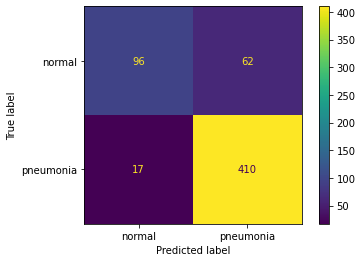

In [9]:
true_labels, model_preds, test_loss, test_accuracy = test(device=device, model=cnn_model, 
                                                          data_loader=test_loader, get_predictions=True)
show_metrics(true_labels=true_labels, model_preds=model_preds)

## Best CNN with AutoEncoder

In [10]:
from math import floor
# kernel size of convolution layers
kernel_size = 3

# sharp sobel kernels (will have to update if kernel size increases)
kernels = [torch.tensor([[0., -1., 0.],
                        [-1., 5., -1.],
                        [0., -1., 0.]]),
           torch.tensor([[1., 2., 1.],
                        [0., 0., 0.],
                        [-1., -2., -1.]]),
           torch.tensor([[1., 0., -1.],
                        [2., 0., -2.],
                        [1., 0., -1.]])]

# number of hidden layers and their sizes
hidden = [256, 256, 128, 64]

# window size of maxpooling layer
window = 2

# calculate final size of image
new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
channels = hidden[-1]
changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 512, 64]

In [11]:
cnn_model = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size,
                  window=window, hidden_linear=hidden_linear, dropout=0.5).to(device)
cnn_model.load_state_dict(torch.load('./CNNwithAE_5epochs')["model_state_dict"])
for param in cnn_model.parameters():
    param.requiresGrad = False

Test loss: 0.4440, Test accuracy: 0.8581
Precision: 0.8788546255506607
Recall: 0.9344262295081968
F1 score: 0.905788876276958


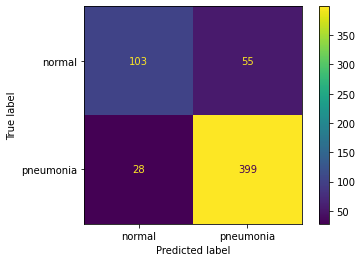

In [12]:
true_labels, model_preds, test_loss, test_accuracy = test(device=device, model=cnn_model, 
                                                          data_loader=test_loader, autoencoder=autoencmodel,
                                                          get_predictions=True)
show_metrics(true_labels=true_labels, model_preds=model_preds)

## Best Transformer

In [13]:
from math import floor
# number of convolutional 'embedding' layers and their sizes
hidden = [1, 256, 64, 32]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img
blocks = [flattened, 512, 64]

In [14]:
transformer = Transformer(hidden, kernel_size, window, blocks).to(device)
transformer.load_state_dict(torch.load('./Transformer_checkpoint')["model_state_dict"])
for param in transformer.parameters():
    param.requiresGrad = False

Test loss: 0.2813, Test accuracy: 0.9043
Precision: 0.8972162740899358
Recall: 0.9812646370023419
F1 score: 0.9373601789709172


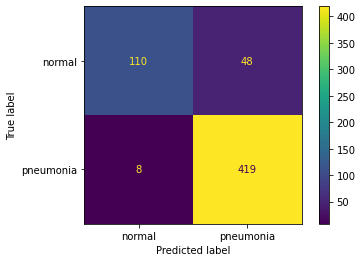

In [15]:
true_labels, model_preds, test_loss, test_accuracy = test(device=device, model=transformer, 
                                                          data_loader=test_loader, get_predictions=True)
show_metrics(true_labels=true_labels, model_preds=model_preds)

## Best Transformer with AutoEncoder

In [16]:
from math import floor
# number of hidden layers and their sizes
hidden = [256, 256, 64, 32]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
new_size = size-(kernel_size_a-1)*(len(hidden_a)-1)
channels = hidden[-1]
changed_img = floor( (new_size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img
blocks = [flattened, 512, 64]

In [17]:
transformer = Transformer(hidden, kernel_size, window, blocks).to(device)
transformer.load_state_dict(torch.load('./Transformer_checkpoint_withAE')["model_state_dict"])
for param in transformer.parameters():
    param.requiresGrad = False

Test loss: 0.2989, Test accuracy: 0.9009
Precision: 0.9019607843137255
Recall: 0.9695550351288056
F1 score: 0.9345372460496614


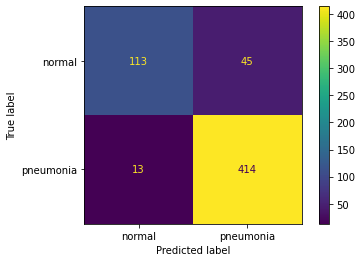

In [18]:
true_labels, model_preds, test_loss, test_accuracy = test(device=device, model=transformer, 
                                                          data_loader=test_loader, autoencoder=autoencmodel,
                                                          get_predictions=True)
show_metrics(true_labels=true_labels, model_preds=model_preds)